In [1]:
# !pip install librosa soundfile numpy sklearn pyaudio #scikit-learn

In [2]:
import os
import numpy as np
import librosa
import soundfile
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

## dataset directory

In [3]:
DATASET_DIR = "data/"

## extract the features from audio files

In [4]:
def extract_features(file_path):
    with soundfile.SoundFile(file_path) as sound_file:
        audio_data = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        mfcss = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        return np.mean(mfcss.T, axis=0)

## create lists for holding the features and lables

In [5]:
features =[]
labels =[]

emotion_labels={
    "01":"neutral",
    "02":"calm",
    "03":"happy",
    "04":"sad",
    "05":"angry",
    "06":"fearful",
    "07":"disgust",
    "08":"suprised"
}

## travarse through the dataset dir, and extract features

In [6]:
file_count = 0
for root, _, files in os.walk(DATASET_DIR):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = emotion_labels.get(file.split("-")[2])
            if emotion:
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(emotion)
                file_count += 1

In [7]:

print(f"Processed {file_count} files.")
print(f"Extracted {len(features)} feature sets.")


Processed 1440 files.
Extracted 1440 feature sets.


In [8]:
# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Check if features and labels are not empty
if features.size == 0 or labels.size == 0:
    raise ValueError("No features or labels extracted. Please check the dataset path and file processing logic.")


In [9]:
# Check if features and labels are not empty
if features.size == 0 or labels.size == 0:
    raise ValueError("No features or labels extracted. Please check the dataset path and file processing logic.")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)


In [11]:
# Initialize and train the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=500)
model.fit(X_train, y_train)


MLPClassifier(max_iter=500)

In [12]:
# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 40.972%


In [13]:
# Save the model to a file
joblib.dump(model, "speech_emotion_recognition_model.pkl")

# Load the model from the file (optional, for later use)
model = joblib.load("speech_emotion_recognition_model.pkl")

# another model now

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Ensure features are 2D (samples, features) for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Encode labels to one-hot vectors
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

2024-05-25 17:59:47.946756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 17:59:48.258403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 17:59:58.393940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
# Define the CNN model
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train_cnn.shape[1], activation='softmax')
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test_cnn))

# Evaluate the model
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the model
model_cnn.save("speech_emotion_recognition_cnn_model.h5")

/mnt/coding/oll/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1481 - loss: 7.0414 - val_accuracy: 0.1076 - val_loss: 2.0872
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1396 - loss: 2.1669 - val_accuracy: 0.1910 - val_loss: 2.0496
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1705 - loss: 2.0834 - val_accuracy: 0.2014 - val_loss: 2.0318
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1427 - loss: 2.0552 - val_accuracy: 0.1701 - val_loss: 2.0183
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2024 - loss: 2.0475 - val_accuracy: 0.2188 - val_loss: 2.0146
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1795 - loss: 2.0398 - val_accuracy: 0.2118 - val_loss: 1.9803
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1942 - loss: 1.9998 - val_accuracy: 0.2153 - val_loss: 1.9751
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2352 - loss: 1.9537 - val_accuracy: 0.2431 - v

Accuracy: 48.61%


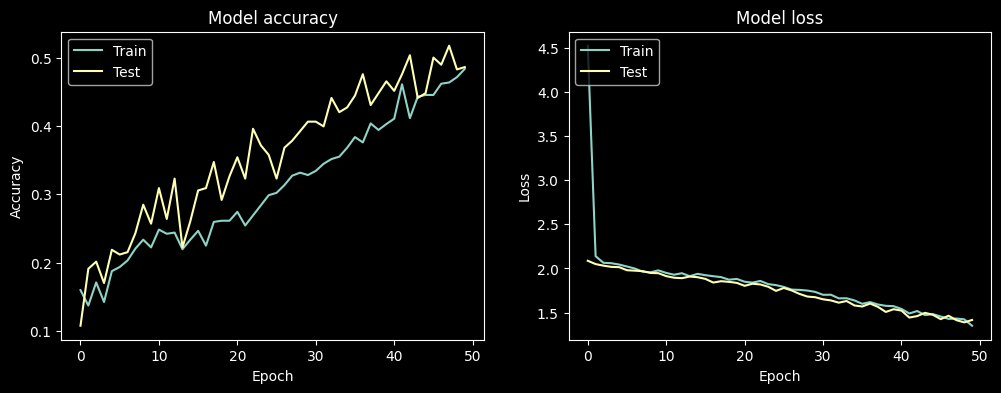

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [18]:
from tensorflow.keras.models import load_model

# Load the model
model_cnn = load_model("speech_emotion_recognition_cnn_model.h5")

# Make predictions
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred_cnn, axis=1)
y_true_labels = np.argmax(y_test_cnn, axis=1)

# Evaluate the accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Loaded model accuracy: {accuracy * 100:.3f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Loaded model accuracy: 48.611%
